In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

## 1.데이터 준비

In [9]:
!gdown https://drive.google.com/uc?id=1-MgHBM01grW2O8N-aVO5p5en16Ko-aH5

Downloading...
From (original): https://drive.google.com/uc?id=1-MgHBM01grW2O8N-aVO5p5en16Ko-aH5
From (redirected): https://drive.google.com/uc?id=1-MgHBM01grW2O8N-aVO5p5en16Ko-aH5&confirm=t&uuid=75b5b169-e4e7-4f5a-a11a-e30c8aa0299f
To: /content/PlantVillage.zip
100% 345M/345M [00:02<00:00, 132MB/s]


In [10]:
!unzip -q 'PlantVillage.zip'

In [11]:
data_root = './PlantVillage'

### 이미지 로딩

In [12]:
class_name = ['early_blight', 'late_blight', 'healthy']

In [13]:
import os

In [14]:
early_blight_fname = os.listdir(data_root + '/Potato___Early_blight')
late_blight_fname = os.listdir(data_root + '/Potato___Late_blight')
healthy_fname = os.listdir(data_root + '/Potato___healthy')

In [15]:
import PIL

In [16]:
X = []
y = []

In [17]:
for fname in early_blight_fname:
  image = PIL.Image.open(data_root + '/Potato___Early_blight/' + fname)
  image = image.resize((224, 224))
  arr = np.array(image)
  X.append(arr)
  y.append(0)

len(X), len(y)

(1000, 1000)

In [18]:
for fname in late_blight_fname:
  image = PIL.Image.open(data_root + '/Potato___Late_blight/' + fname)
  image = image.resize((224, 224))
  arr = np.array(image)
  X.append(arr)
  y.append(1)

len(X), len(y)

(2000, 2000)

In [19]:
for fname in healthy_fname:
  image = PIL.Image.open(data_root + '/Potato___healthy/' + fname)
  image = image.resize((224, 224))
  arr = np.array(image)
  X.append(arr)
  y.append(2)

len(X), len(y)

(2152, 2152)

In [20]:
X = np.array(X)
y = np.array(y)

## 2.데이터 분리

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

In [24]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1376, 224, 224, 3),
 (345, 224, 224, 3),
 (431, 224, 224, 3),
 (1376,),
 (345,),
 (431,))

In [25]:
samples = np.random.randint(1200, size=25)
samples

array([ 750,  357,  537, 1158,  177,  158, 1149, 1010, 1075, 1166,  495,
        771,  691,  280,  180,  425, 1064,   86,  173,  401,  308, 1031,
        286,  704,  616])

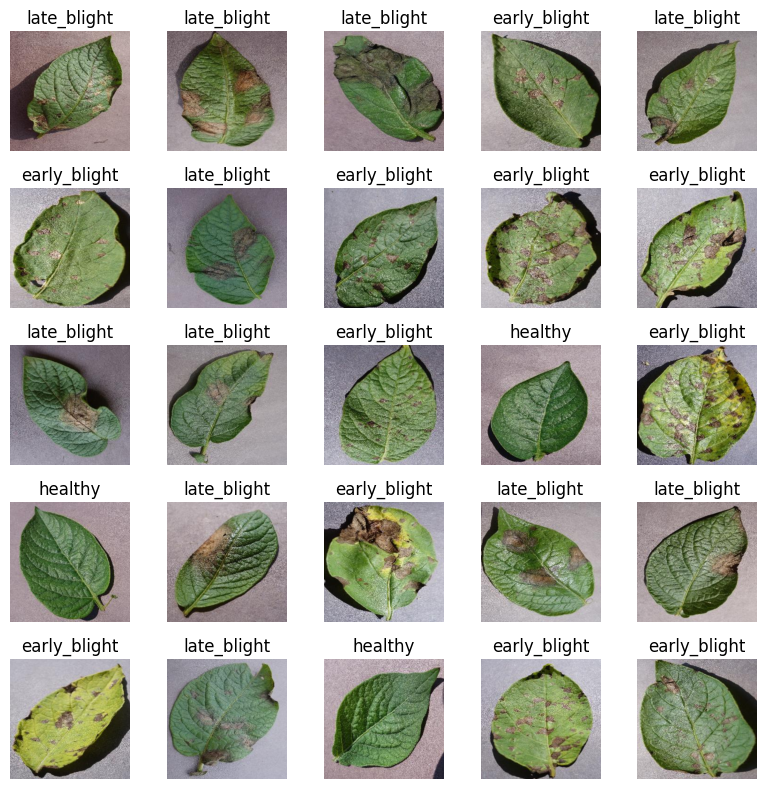

In [26]:
fig = plt.figure(figsize=(8, 8))

for i, idx in enumerate(samples):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.axis('off')
    plt.title(class_name[y_train[idx]])
plt.tight_layout()
plt.show()

### 스케일링

In [27]:
X_train_s = X_train/255.
X_val_s = X_val/255.
X_test_s = X_test/255.

### 원핫인코딩

In [28]:
from keras.utils import to_categorical

In [29]:
y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

In [30]:
y_train_o[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## 4.모델 만들기

In [31]:
from keras.applications import VGG16

In [32]:
base_model = VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
from keras import layers

In [35]:
model = keras.models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=3, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,322,563 (62.27 MB)

 Trainable params: 1,607,875 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [37]:
# early stopping 롤백함수 설정
from keras.callbacks import EarlyStopping

In [38]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
)

In [39]:
EPOCHS = 3
BATCH_SIZE = 32

In [40]:
history = model.fit(
    X_train_s,
    y_train_o,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_s, y_val_o),
    callbacks=[es]
)

Epoch 1/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 474ms/step - acc: 0.6845 - loss: 0.9146 - val_acc: 0.8986 - val_loss: 0.2561
Epoch 2/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - acc: 0.9514 - loss: 0.1461 - val_acc: 0.9130 - val_loss: 0.2328
Epoch 3/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - acc: 0.9693 - loss: 0.0811 - val_acc: 0.9536 - val_loss: 0.1302


### 학습 그래프

In [41]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train_loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='train_acc')
    plt.plot(hist['epoch'], hist['val_acc'], label='val_acc')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

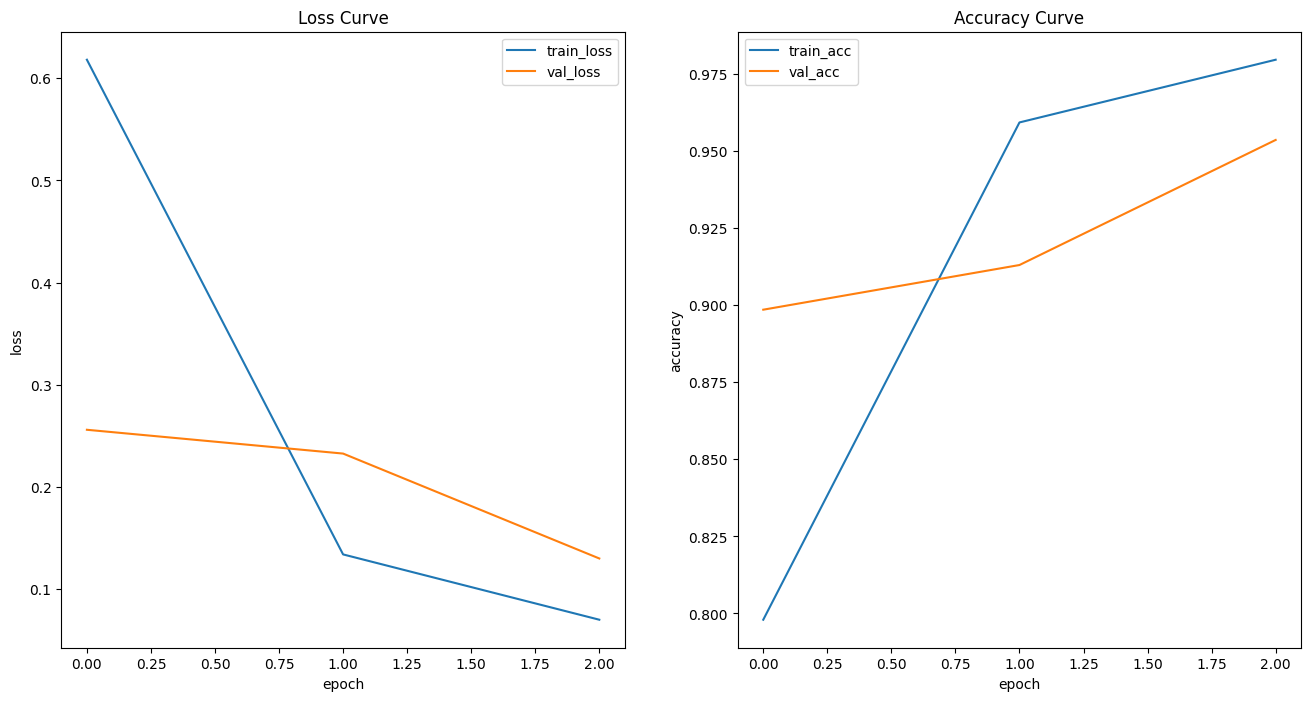

In [42]:
plot_history(history)

## 6.테스트

In [43]:
X_test_s.shape

(431, 224, 224, 3)

In [44]:
y_pred = model.predict(X_test_s)
y_pred

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 840ms/step


array([[7.2859116e-02, 9.0044475e-01, 2.6696157e-02],
       [9.9998522e-01, 1.4605758e-05, 6.2950278e-08],
       [3.3509545e-02, 9.4504446e-01, 2.1445893e-02],
       ...,
       [9.9992776e-01, 6.9580885e-05, 2.5668501e-06],
       [1.7170651e-02, 9.1374213e-01, 6.9087252e-02],
       [9.9946278e-01, 5.1664881e-04, 2.0562606e-05]], dtype=float32)

In [45]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 1, 2,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 2, 1,

In [46]:
y_test

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 1,

## 5.평가지표

In [47]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [48]:
def print_metrics(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  re = recall_score(y_true, y_pred,average='macro')
  pre = precision_score(y_true, y_pred,average='macro')
  f1 = f1_score(y_true, y_pred,average='macro')

  print('acc: ', acc)
  print('recall: ', np.around(re, 4))
  print('precision: ', np.around(pre, 4))
  print('f1: ', np.around(f1, 4))

  cfm = confusion_matrix(y_true, y_pred)
  s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt='d', cbar=False)
  s.set(xlabel='Prediction', ylabel='Actual')
  plt.show()

acc:  0.962877030162413
recall:  0.937
precision:  0.9538
f1:  0.9451


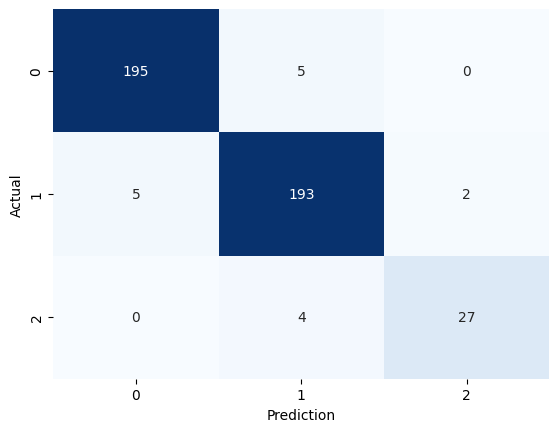

In [49]:
print_metrics(y_test, y_pred)